In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn.functional as F
import sys
from transformers import AutoTokenizer, AutoConfig, GPT2LMHeadModel
from transformers import AutoTokenizer, AutoConfig
# from interp_utils import get_model_from_checkpoint_path
sys.path.append("/datadrive/madhur/world-models/src")
# from training_utils import get_mlp_layers
import eval_utils

from bertviz import model_view, head_view, model_view
torch.set_grad_enabled(False)

from matplotlib import pyplot as plt
from accelerate import Accelerator, DistributedType



In [2]:
# model_path = "../model_3"
# model_path = "/datadrive/madhur/world-models/src/training_outputs/FromSingularity/1cd24e9d-9a34-4da0-987e-527619b49ec8"
# model_path = "/datadrive/madhur/world-models/src/training_outputs/c5de78a0-1b55-45e5-bd11-052e1f0e581d"
# model_path = "/datadrive/madhur/world-models/src/training_outputs/1cd24e9d-9a34-4da0-987e-527619b49ec8"; STEP_NUM=25 # person only ques no trans ATL L=2; H=1; E=128

# person only ques w/ trans ATL L=2; H=1; E=256
# model_path = "/datadrive/madhur/world-models/src/training_outputs/0cef3077-345d-4470-b554-d2988c42aef0"; STEP_NUM=40 # BS=512; LR=5e-5
# model_path = "/datadrive/madhur/world-models/src/training_outputs/25b844c7-9838-447a-b2b3-a351748b71a8"; STEP_NUM=40 # BS=512; LR=1e-4
# model_path = "/datadrive/madhur/world-models/src/training_outputs/723f3bf6-1c21-41c6-9702-f68d9ded720f"; STEP_NUM=35 # BS=128; LR=5e-5 -- 37 epochs done

# 3-digit addition model
# model_path = "/datadrive/madhur/addition_ckpt/checkpoint-59350"

# greater than
model_path = "/datadrive/madhur/world-models/src/training_outputs/greater_than_TFprefix_L1_H1_E8"

# model_path = "/datadrive/madhur/world-models/src/training_outputs/3fb29362-e298-4565-b3e9-acf33061217b"

# model_path = "/datadrive/madhur/world-models/src/training_outputs/cbf01830-50d8-4739-bb86-39f6a8de0bb4" # no PE
# model_path = "/datadrive/madhur/world-models/src/training_outputs/0007e061-f46b-423e-b7b2-19f5479356f4" # no PE, no dropout
# model_path = "/datadrive/madhur/world-models/src/training_outputs/cbf01830-50d8-4739-bb86-39f6a8de0bb4" # no PE
# model_path  = "/datadrive/madhur/world-models/src/training_outputs/cc0f50da-c754-4a08-8269-ac0f2e31f3bf" # transactions; only person questions
# model_path  = "/datadrive/madhur/world-models/src/training_outputs/121f0d35-3b48-4955-9b48-a55b2eb9495b" # transactions; only boolean questions
# model_path  = "/datadrive/madhur/world-models/src/training_outputs/c06ae041-7813-46c7-968e-86c8c910619f" # transactions; only person and boolean questions


### Custom Tokenizers

In [3]:
class customTokenizerAddition():
    def __init__(self,):
        self.bos_token = "B"
        self.eos_token = "E"
        self.pad_token = "P"
        self.bos_token_id = 10
        self.eos_token_id = 13
        self.pad_token_id = 14
        self.special_token_ids = [self.bos_token_id, self.eos_token_id, self.pad_token_id]
        
        self.vocab = {str(i): i for i in range(10)}
        self.vocab[self.bos_token] = self.bos_token_id
        self.vocab[self.eos_token] = self.eos_token_id
        self.vocab[self.pad_token] = self.pad_token_id
        self.vocab["+"] = 11
        self.vocab["="] = 12

        self.vocab_inv = {v: k for k, v in self.vocab.items()}
        self.padding_side = "right"

    def __call__(self, strings, **kwargs):
        # only used by hooked_model.to_tokens()
        if type(strings) == str:
            strings = [strings]
        ids = []
        max_len = max(map(lambda x: len(x), strings))
        for s in strings:
            ids.append( list(map(lambda x: self.vocab[x], s)) + [self.pad_token_id] * (max_len-len(s)) )

        return {"input_ids": torch.LongTensor(ids)}

    def convert_ids_to_tokens(self, ids, rm_special=False):
        if rm_special:
            return [self.vocab_inv[i] for i in ids if i not in self.special_token_ids]
        else:
            return list(map(lambda x: self.vocab_inv[x], ids))

    def __len__(self):
        return len(self.vocab)
    

class customTokenizerGreaterThan():
    def __init__(self,):
        self.bos_token = "B"
        self.eos_token = "E"
        self.pad_token = "P"
        self.bos_token_id = 10
        self.eos_token_id = 11
        self.pad_token_id = 12
        self.special_token_ids = [self.bos_token_id, self.eos_token_id, self.pad_token_id]
        
        self.vocab = {str(i): i for i in range(10)}
        self.vocab[self.bos_token] = self.bos_token_id
        self.vocab[self.eos_token] = self.eos_token_id
        self.vocab[self.pad_token] = self.pad_token_id
        # self.vocab["+"] = 11
        # self.vocab["="] = 12
        self.vocab[">"] = 13
        self.vocab["T"] = 14
        self.vocab["F"] = 15

        self.vocab_inv = {v: k for k, v in self.vocab.items()}
        self.padding_side = "right"

    def __call__(self, strings: list[str] | str, **kwargs):
        # only used by hooked_model.to_tokens()
        if type(strings) == str:
            strings = [strings]
        ids = []
        max_len = max(map(lambda x: len(x), strings))
        for s in strings:
            ids.append( list(map(lambda x: self.vocab[x], s)) + [self.pad_token_id] * (max_len-len(s)) )

        return {"input_ids": torch.LongTensor(ids)}

    def convert_ids_to_tokens(self, ids: list[int], rm_special=False):
        if rm_special:
            return [self.vocab_inv[i] for i in ids if i not in self.special_token_ids]
        else:
            return list(map(lambda x: self.vocab_inv[x], ids))

    def __len__(self):
        return len(self.vocab)

TypeError: 'type' object is not subscriptable

### Rest of the code

In [4]:
# model = GPT2LMHeadModel.from_pretrained(model_path, output_attentions=True, output_hidden_states=True)
# model, config = eval_utils.get_model_from_checkpoint_path(model_path, step_num=STEP_NUM, accelerator = Accelerator(), args=None, \
#     step_or_epoch="epoch", mlp_layers=None, is_no_pos_encode=False, device='cpu', model_load_args={'output_attentions':True, 'output_hidden_states':True})

# model = GPT2LMHeadModel.from_pretrained(model_path)

model = GPT2LMHeadModel.from_pretrained(model_path, output_attentions=True, output_hidden_states=True)
# model.to('cuda:0')
model.eval()
# tokenizer = customTokenizerAddition()
tokenizer = customTokenizerGreaterThan()
# tokenizer = AutoTokenizer.from_pretrained(model_path)
print("model loaded")

OSError: Can't load the configuration of '/datadrive/madhur/world-models/src/training_outputs/greater_than_TFprefix_L1_H1_E8'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure '/datadrive/madhur/world-models/src/training_outputs/greater_than_TFprefix_L1_H1_E8' is the correct path to a directory containing a config.json file

In [17]:
# text = "P8 has O2, O15, O20. P7 has no objects. P8 gives O15 to P7. P8 gives O20 to P7. Who has object O2? Answer: P8."
# text = "P8 has O2, O15, O20. P7 has O16. P8 gives O15, O2, O20 to P7. P7 gives O16, O15, O20 to P8. Who has object O16? Answer: P8."
# text = "P1 has O2, O15, O20. P2 has O16. P3 gives O15, O2, O20 to P4. P5 gives O13, O15, O20 to P6. Who has object O16? Answer: P8."
# text = "P1 has O1, O2, O3. P2 has O7. P3 gives O4, O5, O6 to P4. P8 has O8, O9, O10. P5 gives O11, O12, O13 to P6. Who has object O8? Answer: P8."
# text = "P8 has O2. P7 has O17, O11. P6 has O15, O28. P7 gives O17 to P8. P8 gives O17 to P7. P8 gives O2 to P7. P7 gives O17 to P8. Who has object O2? Answer: P7."
# text = "P7 has O30, O26, O1. P1 has no objects. P9 has O21, O20, O12. P7 gives O30, O26 to P1. Who has object O21? Answer: P9."
# text = "P6 has O25, O13, O1. P9 has O23, O28. P7 has no objects. P9 gives O23, O28 to P7. P6 gives O25, O13 to P7. P6 gives O1 to P9. Who has object O1? Answer: P9."

# text = "P3 has O1, O8, O19. P2 has no objects. Who has object O1? Answer: P3."
# text = "has P3 objects no. P2 has O3, O17, O1. has P10 O11, O15, O5. Who has object ? O1 Answer: P2."
# text = "P3 has objects no. P2 has O1, O17, O3. has P10 O15, O11, O5. Who has object ? O1 Answer: P2."

# text = "P9 has O16. P3 has O12, O1, O27. P3 gives O12 to P9. P9 gives O16 to P3. Who has object O12? Answer: P9."
# text = "P9 has O16. P3 has O12, O1, O27. P3 gives O12 to P9. P9 gives O16 to P3. Does person P9 have object O16? Answer: No."

# text = "P3 has O21, O15, O11. P2 has O1, O17, O3. Who has object O1? Answer: P2."
# text="P3 has O1, O8, O19. P2 has O30. Who has object O1? Answer: P3."
# text = "P3 has O21. P2 has O1, O17, O3. P10 has O15, O11, O5. Who has O1 object? Answer: P2."
# text = "P3 has O21. P2 has O1, O17, O3. P10 has O15, O11, O5. Who O1 has object? Answer: P2."
# text = "P3 has O21. P2 has O1, O17, O3. P10 has O15, O11, O5. O1 Who has object? Answer: P2."
# text = "P3 has O21. P2 has O1, O17, O3. P10 has O15, O11, O5 O1. Who has object? Answer: P2."

# text = "has O21 P3. has P2 O3, O17, O1. has O15, P10 O5, O11. has Who object O5? Answer: P2."
# text = "P9 has O15, O14, O29. P6 has O24, O6, O20. P2 has no objects. Who has object O24? Answer: P6."
# text = "P9 has O15, O14, O29. P6 has O24, O6, O20. P2 has no objects. Who has object O21? Answer: P6."


# text = "403+288=691"
text = "T403>288"
# text = tokenizer.bos_token + ' ' + text + ' ' + tokenizer.eos_token
text = tokenizer.bos_token + text + tokenizer.eos_token
tokenized_data = tokenizer(text)

tokens = tokenizer.convert_ids_to_tokens(tokenized_data["input_ids"][0].tolist())

In [21]:
output = model(torch.tensor(tokenized_data["input_ids"]).unsqueeze(0))
head_view(output.attentions, tokens)

pred4 = output.logits[0,0,-6].argmax().item()
pred3 = output.logits[0,0,-5].argmax().item()
pred2 = output.logits[0,0,-4].argmax().item()
pred1 = output.logits[0,0,-3].argmax().item()

pred_list=[pred4, pred3, pred2, pred1]
print("prediction:", "".join(tokenizer.convert_ids_to_tokens(pred_list)))


/tmp/ipykernel_1239002/3057672206.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(tokenized_data["input_ids"]).unsqueeze(0))


<IPython.core.display.Javascript object>

prediction: =691


In [19]:
output.logits.shape

torch.Size([1, 1, 13, 15])

In [23]:
output.attentions[1].shape


torch.Size([1, 2, 35, 35])

In [11]:
def printneat(A: list):
    for x in A:
        print(f"{x[0]} --> {x[1]}")

In [12]:
def id_to_token_custom(id_list: list):
    token_list = tokenizer.convert_ids_to_tokens(id_list)
    token_list = ["EOS" if x == "<|endoftext|>" else x for x in token_list]
    token_list = ["BOS" if x == "<|startoftext|>" else x for x in token_list]
    return token_list

In [37]:
# ind=28
sent_len = output.attentions[0].shape[2]
lyr=0
head=1
for i in range(sent_len):
    print(f"Attention from token '{id_to_token_custom([tokenized_data['input_ids'][i]])[0]}' to all other tokens")
    printneat(list(zip(id_to_token_custom(tokenized_data['input_ids']), [round(x.item(),3) for x in output.attentions[lyr][0, head, i]  ])))
    print("\n\n")

Attention from token 'BOS' to all other tokens
BOS --> 1.0
P9 --> 0.0
has --> 0.0
O16 --> 0.0
. --> 0.0
P3 --> 0.0
has --> 0.0
O12 --> 0.0
, --> 0.0
O1 --> 0.0
, --> 0.0
O27 --> 0.0
. --> 0.0
P3 --> 0.0
gives --> 0.0
O12 --> 0.0
to --> 0.0
P9 --> 0.0
. --> 0.0
P9 --> 0.0
gives --> 0.0
O16 --> 0.0
to --> 0.0
P3 --> 0.0
. --> 0.0
Does --> 0.0
person --> 0.0
P9 --> 0.0
have --> 0.0
object --> 0.0
O16 --> 0.0
? --> 0.0
Answer --> 0.0
: --> 0.0
No --> 0.0
. --> 0.0
EOS --> 0.0



Attention from token 'P9' to all other tokens
BOS --> 0.968
P9 --> 0.032
has --> 0.0
O16 --> 0.0
. --> 0.0
P3 --> 0.0
has --> 0.0
O12 --> 0.0
, --> 0.0
O1 --> 0.0
, --> 0.0
O27 --> 0.0
. --> 0.0
P3 --> 0.0
gives --> 0.0
O12 --> 0.0
to --> 0.0
P9 --> 0.0
. --> 0.0
P9 --> 0.0
gives --> 0.0
O16 --> 0.0
to --> 0.0
P3 --> 0.0
. --> 0.0
Does --> 0.0
person --> 0.0
P9 --> 0.0
have --> 0.0
object --> 0.0
O16 --> 0.0
? --> 0.0
Answer --> 0.0
: --> 0.0
No --> 0.0
. --> 0.0
EOS --> 0.0



Attention from token 'has' to all oth

In [125]:
output.attentions[0][0, 0, 28]
to

NameError: name 'to' is not defined

In [93]:
tokenized_data

{'input_ids': [1, 14, 5, 40, 4, 15, 5, 26, 6, 43, 6, 27, 4, 18, 5, 28, 6, 35, 6, 53, 4, 10, 5, 11, 53, 8, 9, 7, 15, 4, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [16]:
import os
model_load_args={}
config = AutoConfig.from_pretrained(os.path.join(model_path, "config.json"), )

In [87]:
output.attentions[0][0, 0, 28]


tensor([0.0307, 0.0108, 0.0080, 0.0155, 0.0052, 0.0066, 0.0080, 0.0137, 0.0070,
        0.0149, 0.0070, 0.0155, 0.0052, 0.0107, 0.0080, 0.0151, 0.0070, 0.0165,
        0.0070, 0.0154, 0.0052, 0.2410, 0.0080, 0.1750, 0.0154, 0.0706, 0.1868,
        0.0632, 0.0066, 0.0000, 0.0000])

In [47]:
output.keys()

odict_keys(['logits', 'past_key_values', 'hidden_states', 'attentions'])

In [126]:
output.logits[0, -4]

tensor([-1.9940e-20, -7.1160e-20, -9.8156e-04, -5.4450e-21,  2.8906e-03,
         1.6086e-03, -5.3108e-03, -9.0959e-04, -3.5588e-04,  8.1783e-04,
         2.9112e-03, -9.3722e-04,  1.2760e-03,  7.3061e-04,  6.3377e-02,
         1.0219e+00, -6.9852e-03, -4.9743e-03, -9.2136e-03, -4.3654e-03,
        -4.3699e-03, -1.9597e-02, -1.6038e-02, -3.9332e-03, -2.1184e-03,
        -2.5040e-03,  9.6698e-03, -9.6843e-04,  7.9158e-04, -4.5943e-04,
         1.7483e-04, -2.8708e-03, -1.9997e-03, -2.3815e-03, -1.7304e-03,
        -8.1313e-04, -1.0500e-04, -1.3534e-03, -1.0073e-03, -4.1920e-04,
        -1.3432e-05, -1.1793e-03, -1.1306e-03, -2.2075e-04, -1.4696e-03,
        -9.2369e-04, -1.6329e-03, -1.4093e-03,  7.5302e-04, -3.6104e-04,
        -1.0771e-03, -7.5497e-04, -7.1652e-04,  6.5976e-04])

In [68]:
save_logits = output.logits

In [71]:
save_logits_2 = output.logits


In [72]:
save_logits[0, -4]

tensor([ 4.6196e-08, -6.4366e-06, -9.7719e-05,  6.5509e-07,  1.1804e-03,
         4.9723e-06, -3.8625e-06,  1.2302e-05,  6.5792e-06, -6.3470e-07,
         5.3913e-06,  1.9992e-06,  1.1634e-06, -6.7298e-06,  3.2615e-01,
         3.2142e-01, -3.9194e-03,  1.9756e-04,  3.5324e-01,  1.5087e-03,
         9.1236e-04,  1.7693e-03, -1.1016e-03,  4.1423e-04,  8.4553e-06,
         1.9087e-06,  2.1958e-07, -4.8861e-06,  2.2534e-06, -7.7834e-07,
         2.5698e-06,  8.4716e-06,  3.5903e-06, -1.1313e-05, -3.9548e-06,
         9.6983e-06, -4.1706e-07, -6.7335e-06, -4.8230e-06, -4.1228e-06,
        -3.2548e-06,  4.7712e-06,  5.3671e-06, -5.1722e-06,  3.3596e-06,
         2.3420e-06, -5.4210e-06, -5.5897e-06,  5.2494e-06,  4.3840e-06,
        -1.8534e-06,  8.8052e-06, -2.7101e-06, -5.6266e-06])

In [73]:
save_logits_2[0, -4]

tensor([ 9.6855e-08, -8.6064e-06, -8.4208e-05,  8.3661e-07,  1.1785e-03,
         6.6463e-06, -5.1538e-06,  1.6524e-05,  8.8210e-06, -8.0725e-07,
         7.2098e-06,  2.6794e-06,  1.5712e-06, -9.0226e-06,  3.2165e-01,
         3.2046e-01, -2.4824e-03,  7.7001e-04,  3.5591e-01,  1.8150e-03,
         9.1607e-04,  1.9347e-03, -6.4316e-04,  5.6503e-04,  1.1341e-05,
         2.4991e-06,  3.2020e-07, -6.5324e-06,  3.0116e-06, -1.0015e-06,
         3.4183e-06,  1.1383e-05,  4.7955e-06, -1.5196e-05, -5.2777e-06,
         1.3041e-05, -5.8776e-07, -9.0305e-06, -6.4490e-06, -5.5079e-06,
        -4.3452e-06,  6.3630e-06,  7.1817e-06, -6.9024e-06,  4.4710e-06,
         3.1331e-06, -7.2473e-06, -7.4761e-06,  7.0217e-06,  5.8585e-06,
        -2.4264e-06,  1.1815e-05, -3.6145e-06, -7.5265e-06])

In [79]:
model.state_dict().keys()

odict_keys(['transformer.wte.weight', 'transformer.h.0.ln_1.weight', 'transformer.h.0.ln_1.bias', 'transformer.h.0.attn.c_attn.weight', 'transformer.h.0.attn.c_attn.bias', 'transformer.h.0.attn.c_proj.weight', 'transformer.h.0.attn.c_proj.bias', 'transformer.h.0.ln_2.weight', 'transformer.h.0.ln_2.bias', 'transformer.h.0.mlp.c_fc.weight', 'transformer.h.0.mlp.c_fc.bias', 'transformer.h.0.mlp.c_proj.weight', 'transformer.h.0.mlp.c_proj.bias', 'transformer.h.1.ln_1.weight', 'transformer.h.1.ln_1.bias', 'transformer.h.1.attn.c_attn.weight', 'transformer.h.1.attn.c_attn.bias', 'transformer.h.1.attn.c_proj.weight', 'transformer.h.1.attn.c_proj.bias', 'transformer.h.1.ln_2.weight', 'transformer.h.1.ln_2.bias', 'transformer.h.1.mlp.c_fc.weight', 'transformer.h.1.mlp.c_fc.bias', 'transformer.h.1.mlp.c_proj.weight', 'transformer.h.1.mlp.c_proj.bias', 'transformer.ln_f.weight', 'transformer.ln_f.bias', 'lm_head.weight'])

False

## T-SNE Analysis

In [136]:
E = model.state_dict()['transformer.wte.weight']

In [132]:
# print(model.state_dict()['transformer.wte.weight'].shape)
import json

with open("/datadrive/madhur/world-models/src/tokenizer_local/wm_tokenizer_simpl_no_trans_only_person_ques/tokenizer.json") as f:
    data = json.load(f)

# data["model"]["vocab"]


{'<|UNK|>': 0,
 '<|startoftext|>': 1,
 '<|endoftext|>': 2,
 '<|PAD|>': 3,
 '.': 4,
 'has': 5,
 ',': 6,
 ':': 7,
 '?': 8,
 'Answer': 9,
 'Who': 10,
 'object': 11,
 'no': 12,
 'objects': 13,
 'P3': 14,
 'P2': 15,
 'P5': 16,
 'P8': 17,
 'P10': 18,
 'P1': 19,
 'P7': 20,
 'P6': 21,
 'P4': 22,
 'P9': 23,
 'O12': 24,
 'O20': 25,
 'O1': 26,
 'O3': 27,
 'O15': 28,
 'O8': 29,
 'O28': 30,
 'O14': 31,
 'O10': 32,
 'O27': 33,
 'O6': 34,
 'O11': 35,
 'O4': 36,
 'O7': 37,
 'O22': 38,
 'O2': 39,
 'O21': 40,
 'O24': 41,
 'O29': 42,
 'O17': 43,
 'O18': 44,
 'O30': 45,
 'O13': 46,
 'O23': 47,
 'O25': 48,
 'O26': 49,
 'O19': 50,
 'O16': 51,
 'O9': 52,
 'O5': 53}

In [134]:
inverse_dict = {v:k for k,v in data["model"]["vocab"].items()}
inverse_dict

{0: '<|UNK|>',
 1: '<|startoftext|>',
 2: '<|endoftext|>',
 3: '<|PAD|>',
 4: '.',
 5: 'has',
 6: ',',
 7: ':',
 8: '?',
 9: 'Answer',
 10: 'Who',
 11: 'object',
 12: 'no',
 13: 'objects',
 14: 'P3',
 15: 'P2',
 16: 'P5',
 17: 'P8',
 18: 'P10',
 19: 'P1',
 20: 'P7',
 21: 'P6',
 22: 'P4',
 23: 'P9',
 24: 'O12',
 25: 'O20',
 26: 'O1',
 27: 'O3',
 28: 'O15',
 29: 'O8',
 30: 'O28',
 31: 'O14',
 32: 'O10',
 33: 'O27',
 34: 'O6',
 35: 'O11',
 36: 'O4',
 37: 'O7',
 38: 'O22',
 39: 'O2',
 40: 'O21',
 41: 'O24',
 42: 'O29',
 43: 'O17',
 44: 'O18',
 45: 'O30',
 46: 'O13',
 47: 'O23',
 48: 'O25',
 49: 'O26',
 50: 'O19',
 51: 'O16',
 52: 'O9',
 53: 'O5'}

In [145]:
tokenNamesList = list(inverse_dict.values())

In [152]:
# E = model.state_dict()['transformer.wte.weight'] is a vocab_size x d_emb matrix
# each index corresponds to a token given by inverse_dict
# train a t-SNE model on the embeddings in E, label them and plot on a 2D plot

from sklearn.manifold import TSNE
# Instantialte tsne, specify cosine metric
tsne = TSNE(random_state = 42, n_iter = 10000, metric = 'euclidean', perplexity=15.0, ) # metric = 'euclidean'

In [153]:
embeddings2d = tsne.fit_transform(E)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [154]:
import pandas as pd
# Create DF
embeddingsdf = pd.DataFrame()
# Add game names
embeddingsdf['token'] = tokenNamesList
# Add x coordinate
embeddingsdf['x'] = embeddings2d[:,0]
# Add y coordinate
embeddingsdf['y'] = embeddings2d[:,1]
# Check
embeddingsdf.head()

,token,x,y
0,<|UNK|>,22.825338,-14.796405
1,<|startoftext|>,17.742414,-11.908830
2,<|endoftext|>,-0.313336,17.173639
3,<|PAD|>,17.944935,-17.857420
4,.,-9.846232,4.141822


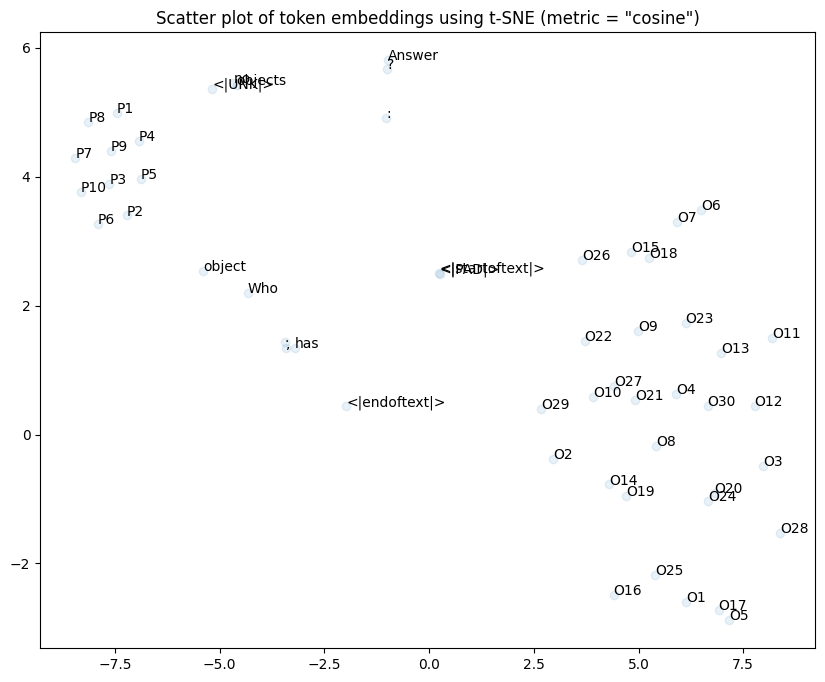

In [151]:
import matplotlib.pyplot as plt

# Set figsize
fig, ax = plt.subplots(figsize=(10,8))
# Scatter points, set alpha low to make points translucent
ax.scatter(embeddingsdf.x, embeddingsdf.y, alpha=.1)

for i, txt in enumerate(tokenNamesList):
    ax.text(embeddingsdf.iloc[i]['x'], embeddingsdf.iloc[i]['y'], txt)


plt.title('Scatter plot of token embeddings using t-SNE (metric = "cosine")')
plt.show()




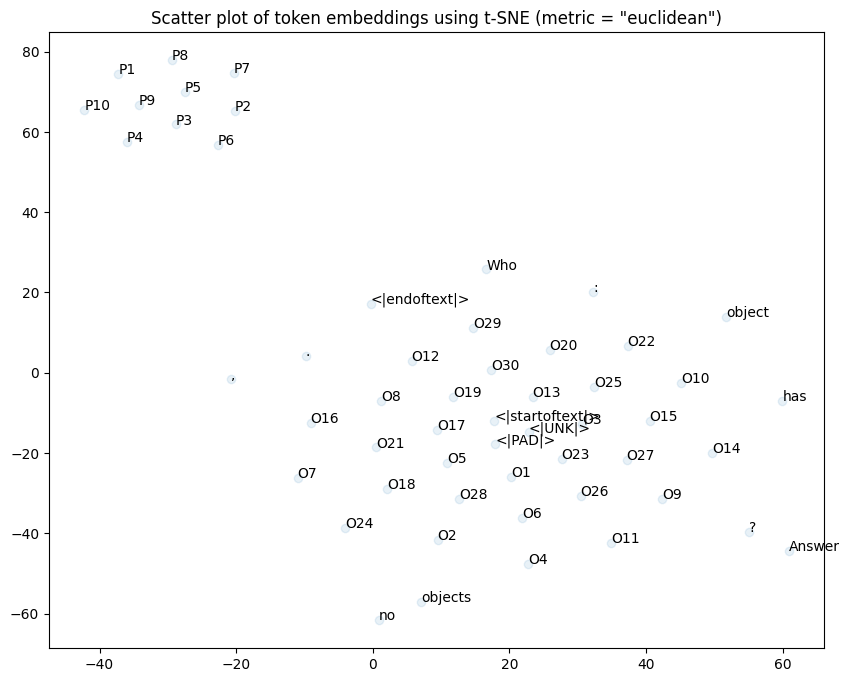

In [155]:
import matplotlib.pyplot as plt

# Set figsize
fig, ax = plt.subplots(figsize=(10,8))
# Scatter points, set alpha low to make points translucent
ax.scatter(embeddingsdf.x, embeddingsdf.y, alpha=.1)

for i, txt in enumerate(tokenNamesList):
    ax.text(embeddingsdf.iloc[i]['x'], embeddingsdf.iloc[i]['y'], txt)


plt.title('Scatter plot of token embeddings using t-SNE (metric = "euclidean")')
plt.show()




In [21]:
output.logits[0,-3]

tensor([-1.4677e-11, -3.9322e-06,  1.9573e-05,  1.5298e-11,  1.0048e+00,
        -1.2279e-05, -2.2601e-04, -3.7266e-06, -3.1380e-05,  4.2381e-05,
         1.6576e-05, -1.5488e-05, -3.9349e-05,  5.0803e-06, -1.9777e-04,
        -1.4713e-04, -2.2572e-04, -2.1462e-04, -2.1793e-04, -2.0855e-04,
        -1.6139e-04, -3.2466e-04, -1.7203e-04, -2.9251e-04, -7.5277e-05,
         2.9414e-05, -9.7893e-05, -1.0382e-04, -6.7502e-05, -8.9449e-05,
        -1.2322e-04, -4.1108e-05, -9.7762e-05, -1.5313e-04, -1.1356e-04,
        -2.2732e-05, -1.3072e-04, -7.2400e-05, -6.1446e-05, -9.8290e-05,
        -9.6772e-05, -5.3377e-05, -6.1058e-05, -1.1434e-05, -1.3150e-04,
        -8.8219e-05, -7.6494e-05, -8.6504e-05, -6.9138e-05, -1.1558e-04,
        -7.8851e-05, -2.0280e-05,  1.0401e-05, -9.0724e-05])

In [ ]:
model_view(output.attentions, tokens)

In [16]:
# text = "P3 has O1, O8, O19. P2 has no objects. Who has object O19? Answer: P3."
text = "P3 has O1, O8, O19. P2 has no objects. Who has object O7? Answer: P2."


text = tokenizer.bos_token + ' ' + text
tokenized_data = tokenizer(text)

tokens = tokenizer.convert_ids_to_tokens(tokenized_data["input_ids"])

output = model(torch.tensor(tokenized_data["input_ids"]).unsqueeze(0))
head_view(output.attentions, tokens)

pred = output.logits[0,-3].argmax().item()
print("prediction:", tokenizer.convert_ids_to_tokens(pred))

<IPython.core.display.Javascript object>

prediction: P3


In [ ]:
text = "P10 has O2. P1 has O23, O14. P3 has no objects. Who has object O14? Answer: P1."

text = tokenizer.bos_token + ' ' + text
tokenized_data = tokenizer(text)

tokens = tokenizer.convert_ids_to_tokens(tokenized_data["input_ids"])

output = model(torch.tensor(tokenized_data["input_ids"]).unsqueeze(0))
head_view(output.attentions, tokens)

pred = output.logits[0,-3].argmax().item()
print("prediction:", tokenizer.convert_ids_to_tokens(pred))


<IPython.core.display.Javascript object>

prediction: P1


In [ ]:
text = "P3 has O12, O28. P6 has O19, O24, O21. Who has object O28? Answer: P3."

text = tokenizer.bos_token + ' ' + text
tokenized_data = tokenizer(text)

tokens = tokenizer.convert_ids_to_tokens(tokenized_data["input_ids"])

output = model(torch.tensor(tokenized_data["input_ids"]).unsqueeze(0))
head_view(output.attentions, tokens)

pred = output.logits[0,-3].argmax().item()
print("prediction:", tokenizer.convert_ids_to_tokens(pred))

<IPython.core.display.Javascript object>

prediction: P3
